## Deconvolving single-cell family size distribution into chimeric and real components

In [10]:
%matplotlib inline

import os
import matplotlib.pylab as plt
from commons import *
from sc_fingerprint import *
from pyro_extras import *
from sc_fsd_mixture_model import *

from pyro.infer import Trace_ELBO
import scipy.sparse as sp
import logging
from collections import Counter
import pickle 

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

## Inputs, outputs, and model hyperparameters

In [11]:
dataset_name = 'pbmc4k'
sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_sc_fingerprint.pkl'
# sc_fingerprint_path = '/home/jupyter/data/10x/pbmc4k_ss_rate_0.25_sc_fingerprint.pkl'

## Train the model

In [14]:
# load fingerprint and instantiate the data-store
sc_fingerprint = SingleCellFingerprint.load(sc_fingerprint_path).filter_genes()
sc_fingerprint_datastore = SingleCellFingerprintDataStore(sc_fingerprint, top_k_genes=1000)

Number of genes failed the maximum Good-Turing criterion: 15350
Number of genes failed the minimum expression criterion: 19742
Number of genes failed both criteria: 15203
Number of retained genes: 13805


In [55]:
gene_index = 197
fp = sc_fingerprint_datastore.fingerprint_array[:, gene_index, :]
fp_zm = fp - np.mean(fp, 0)[None, :]
fp_m = np.sum(fp, 0)
fp_m = fp_m / np.sum(fp_m)

In [56]:
from sklearn.decomposition import PCA, FastICA, NMF

n_components = 2

# ica = FastICA(n_components=n_components)
# pca = PCA(n_components=n_components)
nmf = NMF(init='nndsvd',
          n_components=n_components,
          alpha=10.0,
          l1_ratio=1.0,
          max_iter=10000,
          solver='cd',
          verbose=False,
          tol=1e-6)

nmf.fit(fp)

NMF(alpha=10.0, beta_loss='frobenius', init='nndsvd', l1_ratio=1.0,
  max_iter=10000, n_components=2, random_state=None, shuffle=False,
  solver='cd', tol=1e-06, verbose=False)

In [57]:
# w = nmf.transform(fp)
# plt.plot(np.sum(fp[(w[:, 1] == 0) & (w[:, 2] == 0), :], 0))

(0, 10)

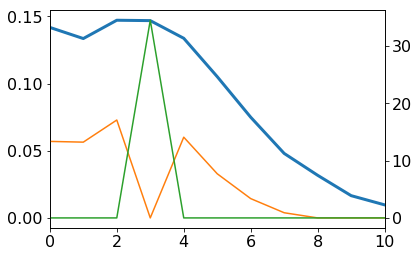

In [58]:
plt.plot(fp_m, lw=3)
ax = plt.twinx()
ax.plot(0)
for j in range(n_components):
    ax.plot(nmf.components_[j,:])
plt.xlim(0, 10)

In [59]:
singleton_ratio = fp[:, 1] / (1e-12 + np.sum(fp, -1))

In [60]:
expr = np.sum(fp, -1)

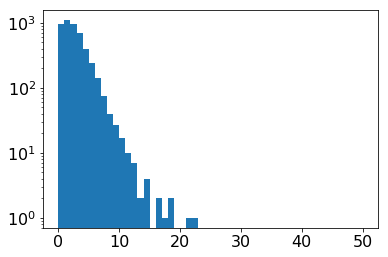

In [61]:
_ = plt.hist(expr, bins=50, range=(0, 50), log='True')

In [78]:
low_fp = np.sum(fp[expr <= 1, :], 0)
hi_fp = np.sum(fp[expr >= 8, :], 0)

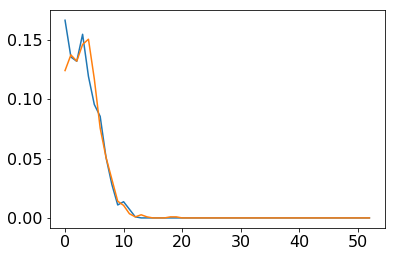

In [79]:
plt.plot(low_fp / np.sum(low_fp))
plt.plot(hi_fp / np.sum(hi_fp))

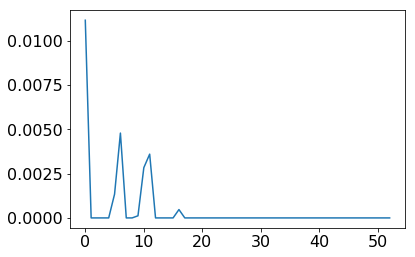

In [583]:
plt.plot(np.maximum(0, low_fp / np.sum(low_fp) - hi_fp / np.sum(hi_fp)))

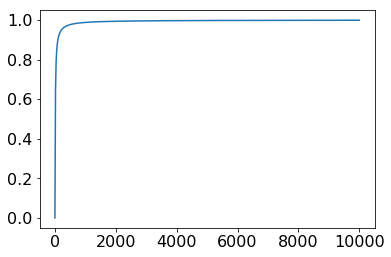

In [16]:
mu = 300.0
phi = np.linspace(0.1, 10000, num=500)
f = np.power((1 / (1 + mu*phi)), 1. / phi)
plt.plot(phi, f)